In [45]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import spacy
from transformers import AutoTokenizer, RobertaModel, BertTokenizer, BertModel
# from surprisal import AutoHuggingFaceModel
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import joblib

from utils import *
from word_fixations import *
from word_properties import *
from regression_model import *
from bert_trt import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
words_dict = get_word_sentence_fixations_dict_from_csv(csv_path='word_sentence_fixations\words_dict_romanian_theo.csv', properties_dir='properties\properties_romanian_theo')

In [3]:
words_dict = compute_average_TRT(words_dict)

In [4]:
for stimulus_key in words_dict:
	print(f"Stimulus: {stimulus_key}")
	for word_idx in words_dict[stimulus_key]:
		print(f"  Word Index: {word_idx}")
		word = words_dict[stimulus_key][word_idx]['word']
		sentence = words_dict[stimulus_key][word_idx]['sentence']
		word_idx_in_sentence = words_dict[stimulus_key][word_idx]['word_idx_in_sentence']
		properties = words_dict[stimulus_key][word_idx]['properties']
		average_TRT = words_dict[stimulus_key][word_idx]['average_TRT']
		print(f"    Word: {word}")
		print(f"    Sentence: {sentence}")
		print(f"    Word Index in Sentence: {word_idx}")
		print(f"    Properties: {properties}")
		print(f"    Average TRT: {average_TRT}")
		for subject_id in words_dict[stimulus_key][word_idx]['subjects_fixations']:
			print(f"      Subject ID: {subject_id}")
			fixations = words_dict[stimulus_key][word_idx]['subjects_fixations'][subject_id]
			print(f"        Fixations: {fixations}")

Stimulus: arg_pisarapanui_11_page_1
  Word Index: 0
    Word: Rapa
    Sentence: Rapa Nui - Introducere
    Word Index in Sentence: 0
    Properties: <word_properties.WordProperties object at 0x000001F2DF4B7130>
    Average TRT: 0.0
      Subject ID: 23
        Fixations: Fixations: [], TRT: 0
  Word Index: 1
    Word: Nui
    Sentence: Rapa Nui - Introducere
    Word Index in Sentence: 1
    Properties: <word_properties.WordProperties object at 0x000001F2DF4B7100>
    Average TRT: 398.0
      Subject ID: 23
        Fixations: Fixations: [206, 192], TRT: 398
  Word Index: 2
    Word: -
    Sentence: Rapa Nui - Introducere
    Word Index in Sentence: 2
    Properties: <word_properties.WordProperties object at 0x000001F2DF4B73D0>
    Average TRT: 0.0
      Subject ID: 23
        Fixations: Fixations: [], TRT: 0
  Word Index: 3
    Word: Introducere
    Sentence: Rapa Nui - Introducere
    Word Index in Sentence: 3
    Properties: <word_properties.WordProperties object at 0x000001F2DF4B76

In [5]:
# Create a dictionary excluding non-page stimuli
words_dict_reading = {}
for stimulus_key in words_dict:
	if 'page' in stimulus_key:
		words_dict_reading[stimulus_key] = words_dict[stimulus_key]

In [6]:
# Compute word properties for each word in the words_dict_reading
for stimulus_key in words_dict_reading:
	for word_idx in words_dict_reading[stimulus_key]:
		print(f"Computing properties for {stimulus_key} - Word Index: {word_idx}")
		words_dict_reading[stimulus_key][word_idx]['properties'].compute_properties()

Computing properties for arg_pisarapanui_11_page_1 - Word Index: 0
Loading surprisal from CSV file...
Computing properties for arg_pisarapanui_11_page_1 - Word Index: 1
Loading surprisal from CSV file...
Computing properties for arg_pisarapanui_11_page_1 - Word Index: 2
Loading surprisal from CSV file...
Computing properties for arg_pisarapanui_11_page_1 - Word Index: 3
Loading surprisal from CSV file...
Computing properties for arg_pisarapanui_11_page_1 - Word Index: 4
Loading surprisal from CSV file...
Computing properties for arg_pisarapanui_11_page_1 - Word Index: 5
Loading surprisal from CSV file...
Computing properties for arg_pisarapanui_11_page_1 - Word Index: 6
Loading surprisal from CSV file...
Computing properties for arg_pisarapanui_11_page_1 - Word Index: 7
Loading surprisal from CSV file...
Computing properties for arg_pisarapanui_11_page_1 - Word Index: 8
Loading surprisal from CSV file...
Computing properties for arg_pisarapanui_11_page_1 - Word Index: 9
Loading surpris

In [7]:
# Compute properties that require all sentences
# Compute transformer embeddings for each word in the words_dict_reading
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")
model = BertModel.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")
model.to(device)

# Extract sentences and word_ids
sentences = [words_dict_reading[stimulus_key][word_idx]['sentence'] for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]]
# Eliminate duplicates but keep the original order
seen = set()
unique_sentences = [s for s in sentences if not (s in seen or seen.add(s))]
sentences = unique_sentences
word_ids = [words_dict_reading[stimulus_key][word_idx]['word_id'] for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]]

# print(f"Sentences: {sentences}")
# print(f"Word IDs: {word_ids}")

model.eval()

with torch.no_grad():
    encoded_inputs = tokenizer(sentences, return_tensors='pt', padding=True, return_offsets_mapping=True, truncation=False)

    offsets = encoded_inputs.pop("offset_mapping")

    outputs = model(**encoded_inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states

embeddings_first_layer = hidden_states[1]
embeddings_middle_layer = hidden_states[6]
embeddings_last_layer = hidden_states[-1]
embeddings_avg = torch.mean(torch.stack(hidden_states), dim=0)

bert_embeddings_first_layer = transformer_embedding(word_ids=word_ids, embeddings=embeddings_first_layer, offsets=offsets)
bert_embeddings_middle_layer = transformer_embedding(word_ids=word_ids, embeddings=embeddings_middle_layer, offsets=offsets)
bert_embeddings_last_layer = transformer_embedding(word_ids=word_ids, embeddings=embeddings_last_layer, offsets=offsets)
bert_embeddings_avg = transformer_embedding(word_ids=word_ids, embeddings=embeddings_avg, offsets=offsets)

# Add the BERT embeddings to the words_dict_reading
for stimulus_key in words_dict_reading:
	for word_idx in words_dict_reading[stimulus_key]:
		word_id = words_dict_reading[stimulus_key][word_idx]['word_id']
		words_dict_reading[stimulus_key][word_idx]['properties'].transformer_embedding_first_layer = bert_embeddings_first_layer[word_id]
		words_dict_reading[stimulus_key][word_idx]['properties'].transformer_embedding_middle_layer = bert_embeddings_middle_layer[word_id]
		words_dict_reading[stimulus_key][word_idx]['properties'].transformer_embedding_last_layer = bert_embeddings_last_layer[word_id]
		words_dict_reading[stimulus_key][word_idx]['properties'].transformer_embedding_avg = bert_embeddings_avg[word_id]

In [138]:
# Create a dictionary excluding skipped words (words with 0 TRT)
words_dict_non_skipped = {}
for stimulus_key in words_dict_reading:
	words_dict_non_skipped[stimulus_key] = {}
	for word_idx in words_dict_reading[stimulus_key]:
		if words_dict_reading[stimulus_key][word_idx]['average_TRT'] > 0:
			words_dict_non_skipped[stimulus_key][word_idx] = words_dict_reading[stimulus_key][word_idx]

In [8]:
# Numpy arrays
trt_reading = np.array([words_dict_reading[stimulus_key][word_idx]['average_TRT'] for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]])
length_reading = np.array([words_dict_reading[stimulus_key][word_idx]['properties'].length for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]])
freq_reading = np.array([words_dict_reading[stimulus_key][word_idx]['properties'].frequency for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]])
surprisal_reading = np.array([words_dict_reading[stimulus_key][word_idx]['properties'].surprisal for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]])
transformer_embedding_first_layer_reading = np.array([words_dict_reading[stimulus_key][word_idx]['properties'].transformer_embedding_first_layer for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]])
transformer_embedding_middle_layer_reading = np.array([words_dict_reading[stimulus_key][word_idx]['properties'].transformer_embedding_middle_layer for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]])
transformer_embedding_last_layer_reading = np.array([words_dict_reading[stimulus_key][word_idx]['properties'].transformer_embedding_last_layer for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]])
transformer_embedding_avg_reading = np.array([words_dict_reading[stimulus_key][word_idx]['properties'].transformer_embedding_avg for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]])

In [139]:
trt_non_skipped = np.array([words_dict_non_skipped[stimulus_key][word_idx]['average_TRT'] for stimulus_key in words_dict_non_skipped for word_idx in words_dict_non_skipped[stimulus_key]])
length_non_skipped = np.array([words_dict_non_skipped[stimulus_key][word_idx]['properties'].length for stimulus_key in words_dict_non_skipped for word_idx in words_dict_non_skipped[stimulus_key]])
freq_non_skipped = np.array([words_dict_non_skipped[stimulus_key][word_idx]['properties'].frequency for stimulus_key in words_dict_non_skipped for word_idx in words_dict_non_skipped[stimulus_key]])
surprisal_non_skipped = np.array([words_dict_non_skipped[stimulus_key][word_idx]['properties'].surprisal for stimulus_key in words_dict_non_skipped for word_idx in words_dict_non_skipped[stimulus_key]])
transformer_embedding_first_layer_non_skipped = np.array([words_dict_non_skipped[stimulus_key][word_idx]['properties'].transformer_embedding_first_layer for stimulus_key in words_dict_non_skipped for word_idx in words_dict_non_skipped[stimulus_key]])
transformer_embedding_middle_layer_non_skipped = np.array([words_dict_non_skipped[stimulus_key][word_idx]['properties'].transformer_embedding_middle_layer for stimulus_key in words_dict_non_skipped for word_idx in words_dict_non_skipped[stimulus_key]])
transformer_embedding_last_layer_non_skipped = np.array([words_dict_non_skipped[stimulus_key][word_idx]['properties'].transformer_embedding_last_layer for stimulus_key in words_dict_non_skipped for word_idx in words_dict_non_skipped[stimulus_key]])
transformer_embedding_avg_non_skipped = np.array([words_dict_non_skipped[stimulus_key][word_idx]['properties'].transformer_embedding_avg for stimulus_key in words_dict_non_skipped for word_idx in words_dict_non_skipped[stimulus_key]])

In [9]:
length_corr_reading = np.corrcoef(trt_reading, length_reading)[0, 1]
freq_corr_reading = np.corrcoef(trt_reading, freq_reading)[0, 1]
surprisal_corr_reading = np.corrcoef(trt_reading, surprisal_reading)[0, 1]
print(f"Correlation between TRT and length (reading): {length_corr_reading}")
print(f"Correlation between TRT and frequency (reading): {freq_corr_reading}")
print(f"Correlation between TRT and surprisal (reading): {surprisal_corr_reading}")

Correlation between TRT and length (reading): 0.5351942644719594
Correlation between TRT and frequency (reading): -0.3037778554417768
Correlation between TRT and surprisal (reading): 0.30917908605678707


In [143]:
length_corr_non_skipped = np.corrcoef(trt_non_skipped, length_non_skipped)[0, 1]
freq_corr_non_skipped = np.corrcoef(trt_non_skipped, freq_non_skipped)[0, 1]
surprisal_corr_non_skipped = np.corrcoef(trt_non_skipped, surprisal_non_skipped)[0, 1]
print(f"Correlation between TRT and length (non-skipped): {length_corr_non_skipped}")
print(f"Correlation between TRT and frequency (non-skipped): {freq_corr_non_skipped}")
print(f"Correlation between TRT and surprisal (non-skipped): {surprisal_corr_non_skipped}")

Correlation between TRT and length (non-skipped): 0.4002008352145763
Correlation between TRT and frequency (non-skipped): -0.16489109219113396
Correlation between TRT and surprisal (non-skipped): 0.15414989161954115


Model: LinearRegression
  MSE: 35757.4799
  R^2: 0.2670
  Pearson Correlation: 0.5186
  Spearman Correlation: 0.5700


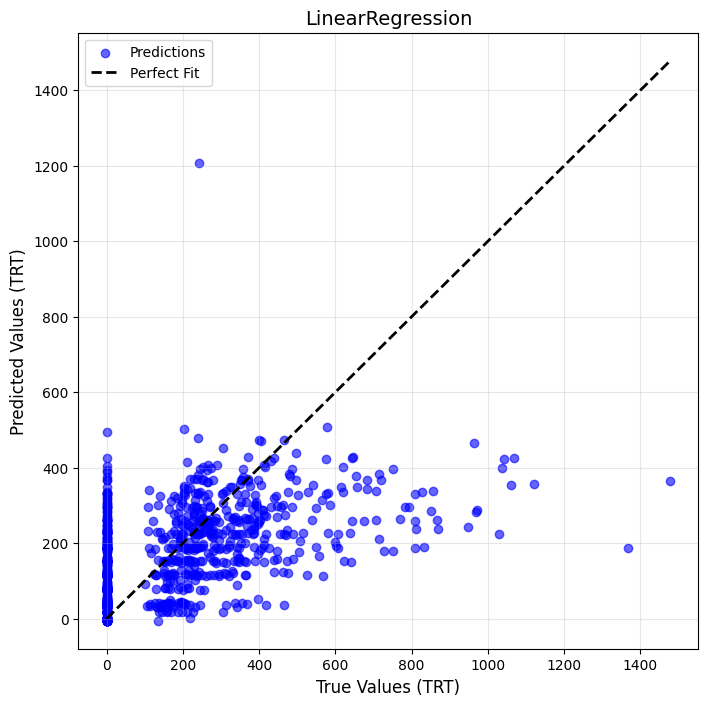

Model: ElasticNet
  MSE: 35610.5757
  R^2: 0.2700
  Pearson Correlation: 0.5206
  Spearman Correlation: 0.5714


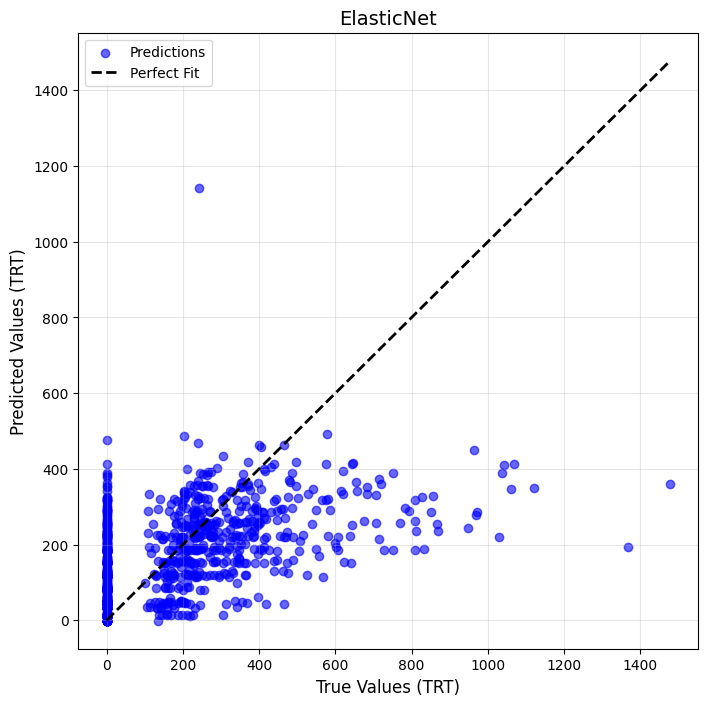

Model: SGDRegressor
  MSE: 35933.7549
  R^2: 0.2634
  Pearson Correlation: 0.5186
  Spearman Correlation: 0.5700


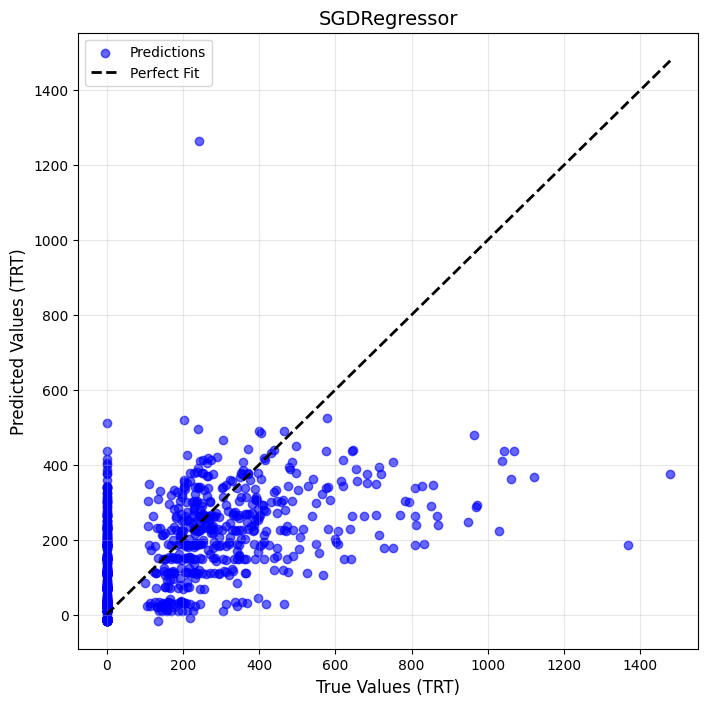

Model: BayesianRidge
  MSE: 35748.6883
  R^2: 0.2672
  Pearson Correlation: 0.5187
  Spearman Correlation: 0.5702


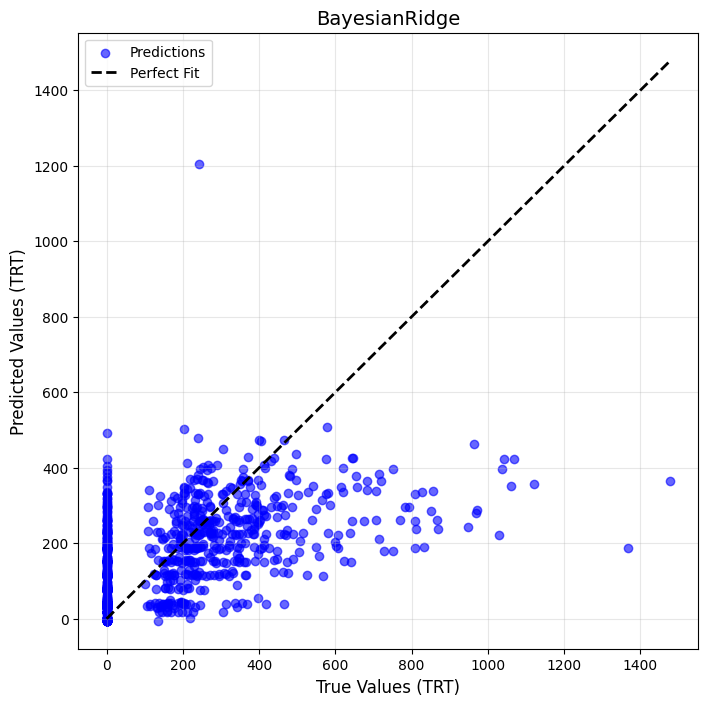

Model: SVR
  MSE: 37807.5888
  R^2: 0.2250
  Pearson Correlation: 0.5207
  Spearman Correlation: 0.5675


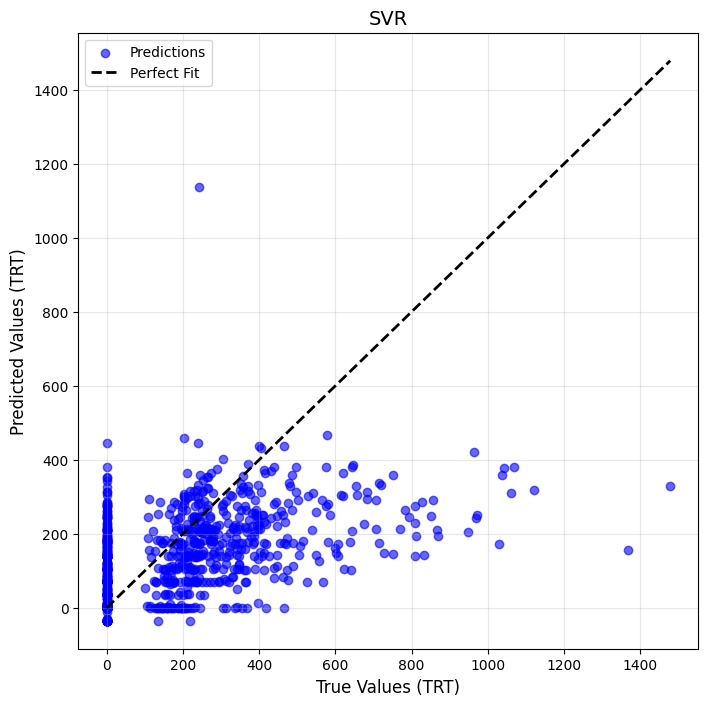

Model: SVR
  MSE: 39486.3840
  R^2: 0.1906
  Pearson Correlation: 0.5117
  Spearman Correlation: 0.5407


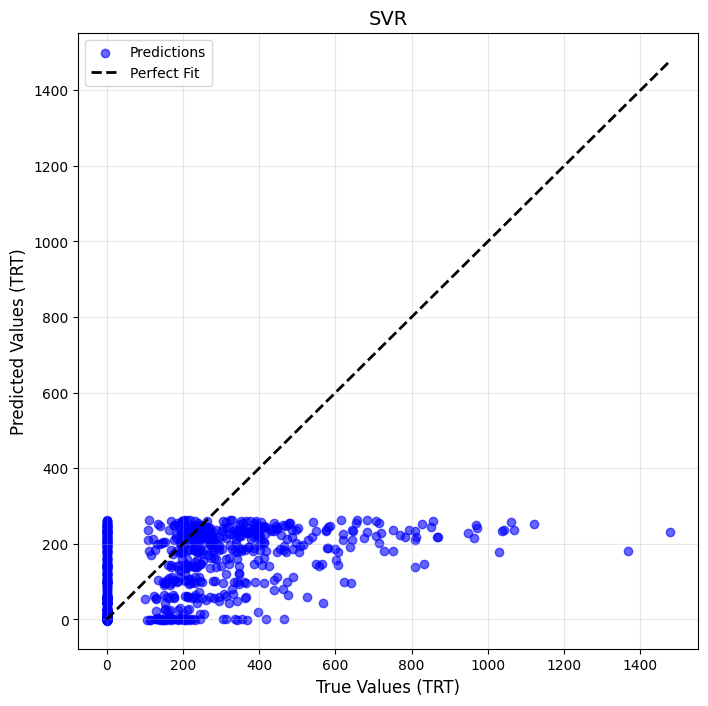

Model: KNeighborsRegressor
  MSE: 40404.4920
  R^2: 0.1717
  Pearson Correlation: 0.4586
  Spearman Correlation: 0.5339


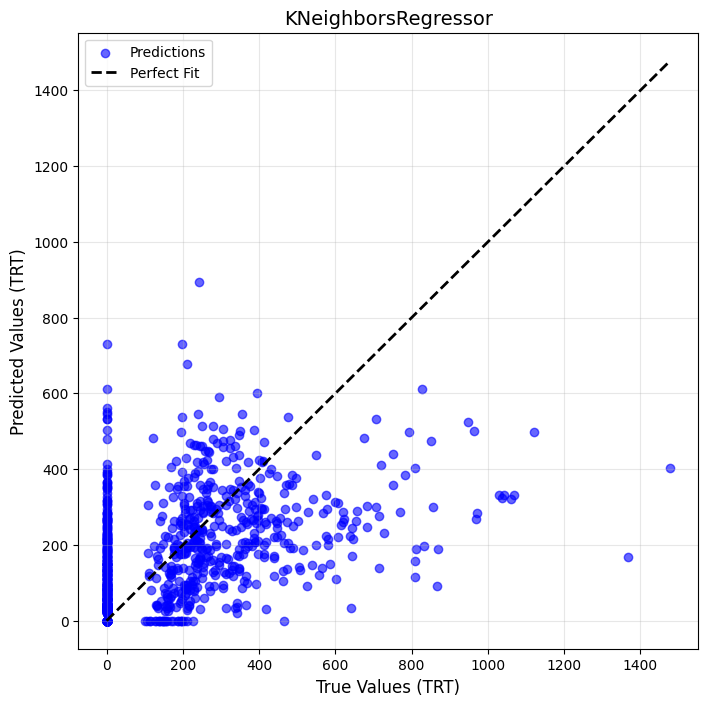

Model: RandomForestRegressor
  MSE: 40797.6129
  R^2: 0.1637
  Pearson Correlation: 0.4547
  Spearman Correlation: 0.5223


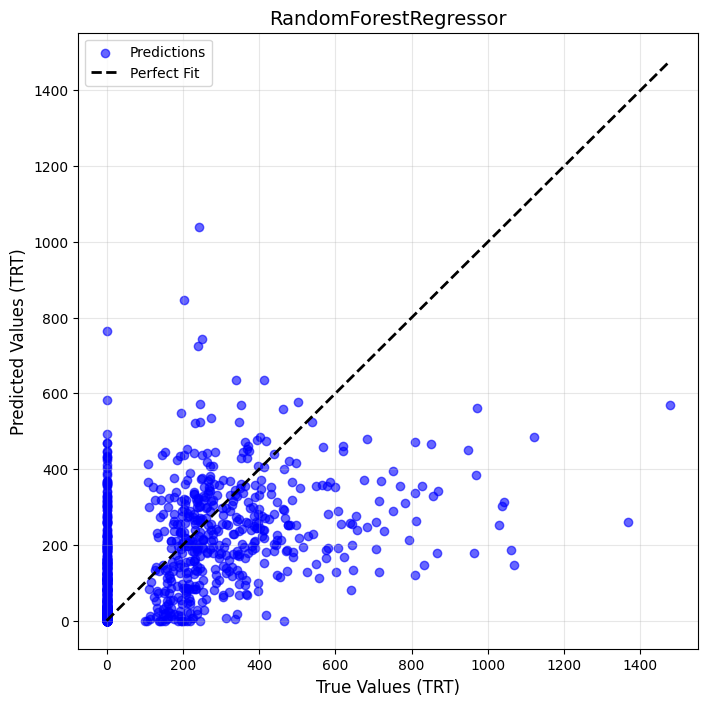

Model: GradientBoostingRegressor
  MSE: 35177.4945
  R^2: 0.2789
  Pearson Correlation: 0.5300
  Spearman Correlation: 0.5651


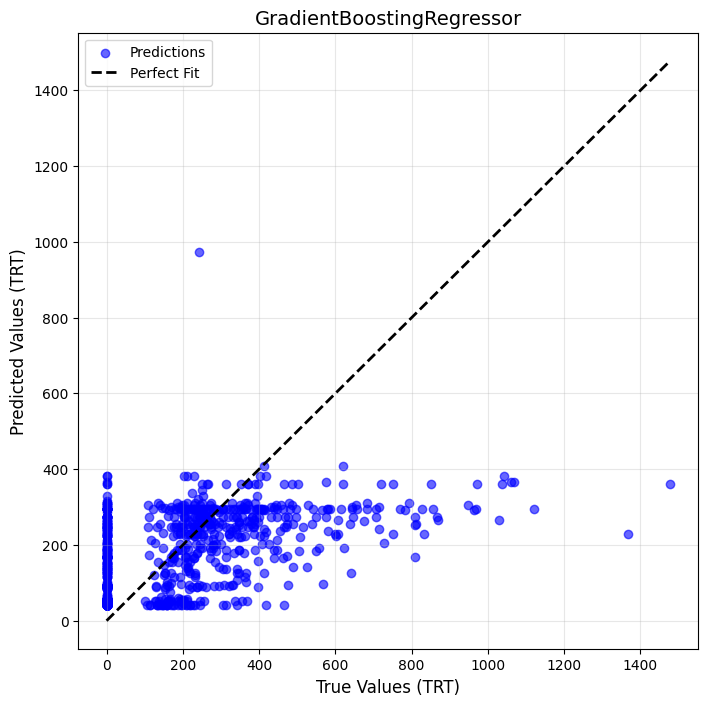

Model: HistGradientBoostingRegressor
  MSE: 36660.1548
  R^2: 0.2485
  Pearson Correlation: 0.5046
  Spearman Correlation: 0.5682


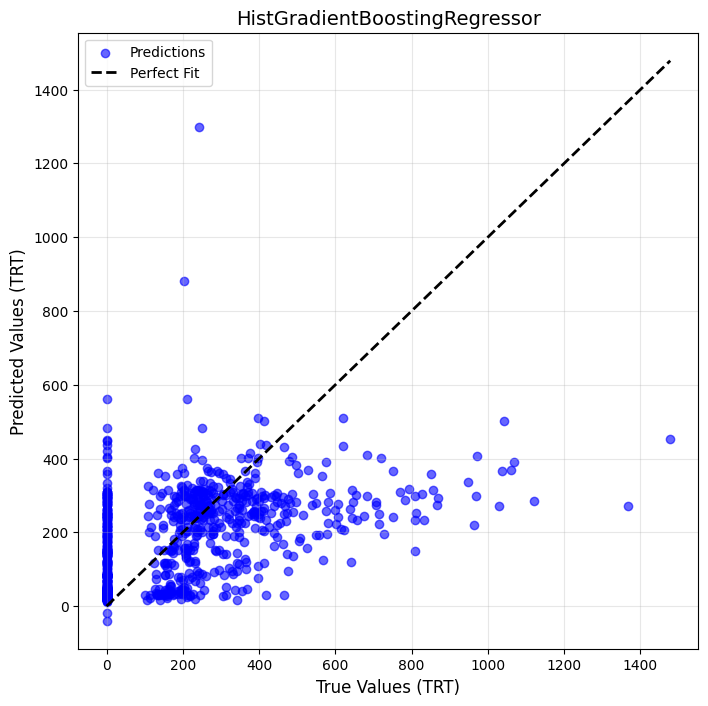

Model: DecisionTreeRegressor
  MSE: 76842.5838
  R^2: -0.5752
  Pearson Correlation: 0.2605
  Spearman Correlation: 0.3370


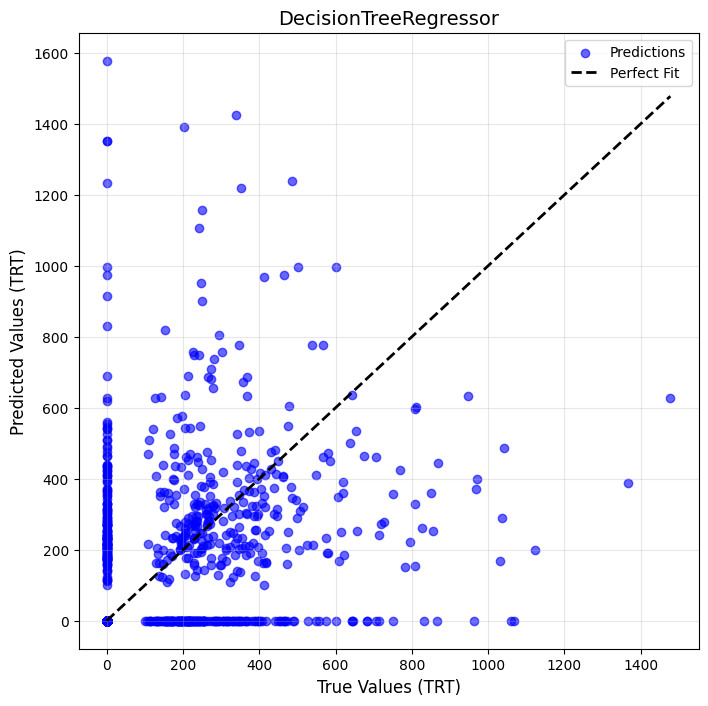

Model: KernelRidge
  MSE: 67260.7778
  R^2: -0.3788
  Pearson Correlation: 0.5186
  Spearman Correlation: 0.5700


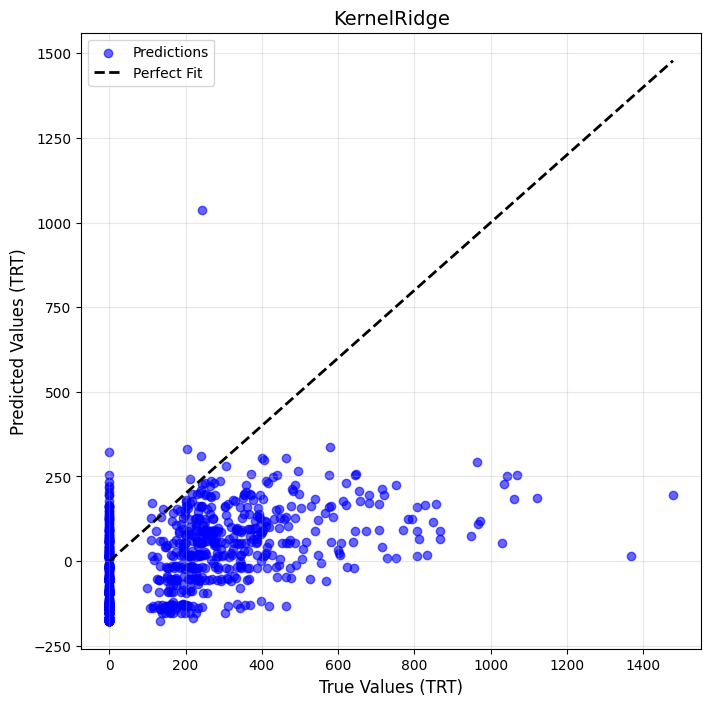

Model: KernelRidge
  MSE: 35125.1151
  R^2: 0.2800
  Pearson Correlation: 0.5301
  Spearman Correlation: 0.5681


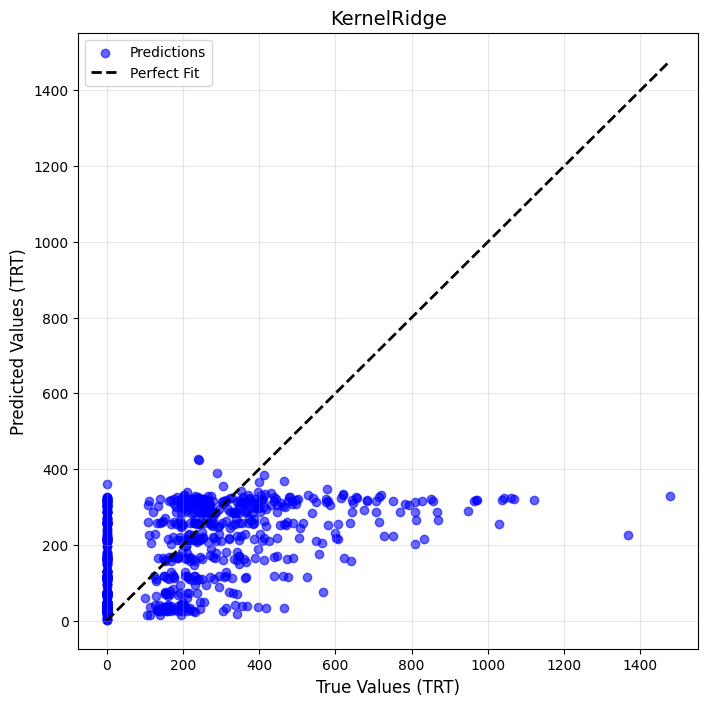

Model: MLPRegressor
  MSE: 36786.6484
  R^2: 0.2459
  Pearson Correlation: 0.5022
  Spearman Correlation: 0.5747


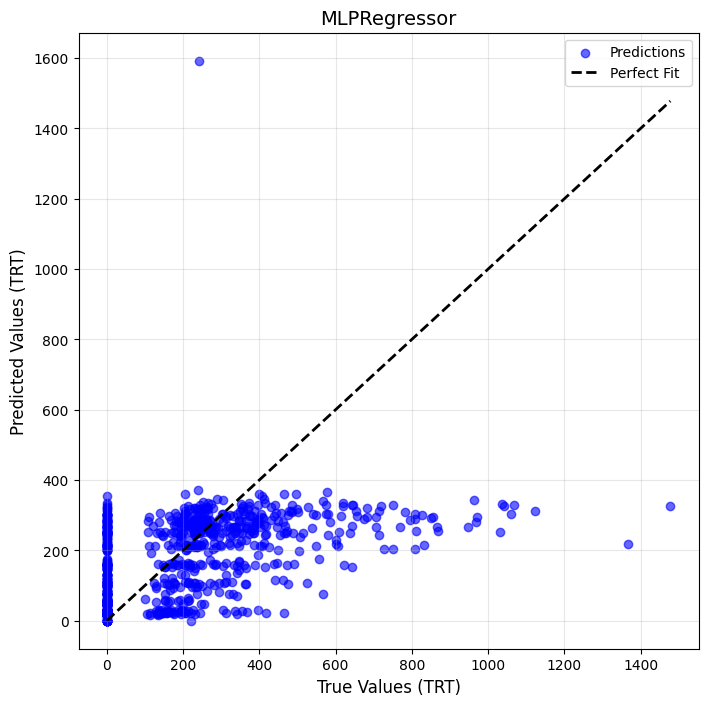

In [13]:
# Train models
X = np.column_stack((length_reading, freq_reading, surprisal_reading))
# X = np.column_stack((length_non_skipped, freq_non_skipped, surprisal_non_skipped))
# X = transformer_embedding_avg_reading

# Standardize TRT
mean_trt = np.mean(trt_reading)
std_trt = np.std(trt_reading)
trt_standardized = (trt_reading - mean_trt) / std_trt

# Normalize TRT to range [0, 1]
min_trt = np.min(trt_reading)
max_trt = np.max(trt_reading)
trt_normalized = (trt_reading - min_trt) / (max_trt - min_trt)

# Robust scaling
median_trt = np.median(trt_reading)
q1 = np.percentile(trt_reading, 25)  # First quartile
q3 = np.percentile(trt_reading, 75)  # Third quartile
iqr = q3 - q1
trt_robust_scaled = (trt_reading - median_trt) / iqr

y = trt_reading
# y = trt_non_skipped
# y = trt_standardized
# y = trt_normalized
# y = trt_robust_scaled

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = [
    LinearRegression(),
    ElasticNet(alpha=0.1, l1_ratio=0.5),
    SGDRegressor(max_iter=1000, tol=1e-3),
    BayesianRidge(),
	SVR(kernel='linear'),
    SVR(kernel='rbf'),
	KNeighborsRegressor(n_neighbors=5),
	RandomForestRegressor(n_estimators=50, random_state=42),
	GradientBoostingRegressor(n_estimators=25, learning_rate=0.1, max_depth=3, random_state=42),
	HistGradientBoostingRegressor(learning_rate=0.1, max_depth=3, random_state=42),
    DecisionTreeRegressor(random_state=42),
    KernelRidge(kernel='linear'),
	KernelRidge(kernel='rbf'),
	MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, learning_rate_init=0.01, random_state=42)
]

for model in models:
	model.fit(X_train_scaled, y_train)
	y_pred = model.predict(X_test_scaled)

	# Calculate metrics
	mse = mean_squared_error(y_test, y_pred)
	r2 = r2_score(y_test, y_pred)
	pearson_corr = pearsonr(y_test, y_pred)[0]
	spearman_corr = spearmanr(y_test, y_pred)[0]

	print(f"Model: {model.__class__.__name__}")
	print(f"  MSE: {mse:.4f}")
	print(f"  R^2: {r2:.4f}")
	print(f"  Pearson Correlation: {pearson_corr:.4f}")
	print(f"  Spearman Correlation: {spearman_corr:.4f}")

	# Plotting the results
	plt.figure(figsize=(8, 8))
	plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label='Predictions')
	plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Fit') 
	plt.xlabel('True Values (TRT)', fontsize=12)
	plt.ylabel('Predicted Values (TRT)', fontsize=12)
	plt.title(f'{model.__class__.__name__}', fontsize=14)
	plt.legend()
	plt.grid(alpha=0.3)
	plt.show()

In [47]:
# X = np.column_stack((length_reading, freq_reading, surprisal_reading))
# X = np.column_stack((length_non_skipped, freq_non_skipped, surprisal_non_skipped))
# X = transformer_embedding_avg_reading
X = np.column_stack((length_reading, freq_reading, surprisal_reading, transformer_embedding_avg_reading))

# Standardize TRT
mean_trt = np.mean(trt_reading)
std_trt = np.std(trt_reading)
trt_standardized = (trt_reading - mean_trt) / std_trt

# Normalize TRT to range [0, 1]
min_trt = np.min(trt_reading)
max_trt = np.max(trt_reading)
trt_normalized = (trt_reading - min_trt) / (max_trt - min_trt)

# Robust scalings
median_trt = np.median(trt_reading)
q1 = np.percentile(trt_reading, 25)  # First quartile
q3 = np.percentile(trt_reading, 75)  # Third quartile
iqr = q3 - q1
trt_robust_scaled = (trt_reading - median_trt) / iqr

y = trt_reading
# y = trt_standardized

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

# gss = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
# for dev_index, test_index in gss.split(X_test, y_test, groups=sentence[test_index]):
#     X_dev, X_test = X_test[dev_index], X_test[test_index]
#     y_dev, y_test = y_test[dev_index], y_test[test_index]

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_dev_tensor = torch.tensor(X_dev, dtype=torch.float32)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
validation_dataset = TensorDataset(X_dev_tensor, y_dev_tensor)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=32, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

model = RegressionModel(input_dim=X_train.shape[1])
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
save_path = 'best_regression_model.pth'
num_epochs = 60
train_regression_model(model=model, train_loader=train_loader, validation_loader=validation_loader, criterion=criterion, optimizer=optimizer, scheduler=scheduler, save_path=save_path, num_epochs=num_epochs)
# Load the best model
model.load_state_dict(torch.load(save_path))
loss_test, r2_test, pearson_test, spearman_test = evaluate_regression_model(model=model, test_loader=test_loader, criterion=criterion)
print(f"Test Loss: {loss_test:.4f}")
print(f"Test R^2: {r2_test:.4f}")
print(f"Test Pearson Correlation: {pearson_test:.4f}")
print(f"Test Spearman Correlation: {spearman_test:.4f}")

Validation loss: 79980.9375
R^2 on validation set: -0.6792341470718384
Pearson correlation on validation set: 0.023440237491856284
Spearman correlation on validation set: 0.0594617296470608
Epoch 5, Loss: 158448.359375
Validation loss: 77780.0078125
R^2 on validation set: -0.6330248117446899
Pearson correlation on validation set: 0.48052254493626184
Spearman correlation on validation set: 0.5116154885202366
Epoch 10, Loss: 22375.79296875
Validation loss: 43459.79296875
R^2 on validation set: 0.08754289150238037
Pearson correlation on validation set: 0.5233539078671534
Spearman correlation on validation set: 0.5492656144422423
Epoch 15, Loss: 22020.365234375
Validation loss: 36309.41015625
R^2 on validation set: 0.23766827583312988
Pearson correlation on validation set: 0.5414592828178117
Spearman correlation on validation set: 0.5671587070244922
Epoch 20, Loss: 71165.609375
Validation loss: 34276.1640625
R^2 on validation set: 0.2803572416305542
Pearson correlation on validation set: 0

In [34]:
# BERT Regression

# Get info from words_dict_reading
words = [words_dict_reading[stimulus_key][word_idx]['word'] for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]]
sentences = [words_dict_reading[stimulus_key][word_idx]['sentence'] for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]]
sentence_ids = [words_dict_reading[stimulus_key][word_idx]['sentence_id'] for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]]
trt = [words_dict_reading[stimulus_key][word_idx]['average_TRT'] for stimulus_key in words_dict_reading for word_idx in words_dict_reading[stimulus_key]]

# Build data_sentences dictionary
# Key: sentence_id
# Value: dictionary with keys 'sentence', 'words', and 'trt'
data_sentences = dict()
for i in range(len(words)):
    if sentence_ids[i] not in data_sentences:
        data_sentences[sentence_ids[i]] = {
            'sentence': sentences[i],
            'words': [],
            'trt': []
		}
    data_sentences[sentence_ids[i]]['words'].append(words[i])
    data_sentences[sentence_ids[i]]['trt'].append(trt[i])

def normalize_trt(trt_list, min_val, max_val):
    return [(t - min_val) / (max_val - min_val) for t in trt_list]

max_trt = max([max(data_sentences[sentence_id]['trt']) for sentence_id in data_sentences])
min_trt = min([min(data_sentences[sentence_id]['trt']) for sentence_id in data_sentences])
for sentence_id in data_sentences:
	data_sentences[sentence_id]['trt'] = normalize_trt(data_sentences[sentence_id]['trt'], min_trt, max_trt)
    
# Print data_sentences for verification
# for sentence_id, data in data_sentences.items():
# 	print(f"Sentence ID: {sentence_id}")
# 	print(f"  Sentence: {data['sentence']}")
# 	print(f"  Words: {data['words']}")
# 	print(f"  TRT: {data['trt']}")
     
# Convert data_sentences to DataFrame to use it for dataset
data_sentences = pd.DataFrame(data_sentences).T

# Split the data into train, test and validation
train_dataset = data_sentences.sample(frac=0.8, random_state=200)
test_dataset = data_sentences.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)
validation_dataset = test_dataset.sample(frac=0.5, random_state=200)
test_dataset = test_dataset.drop(validation_dataset.index).reset_index(drop=True)
validation_dataset = validation_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data_sentences.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALIDATION Dataset: {}".format(validation_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# print(train_dataset.head())

# Set some parameters
MAX_LEN = 512 # for BERT
batch_size = 8
tokenizer = BertTokenizer.from_pretrained("dumitrescustefan/bert-base-romanian-cased-v1")
best_model_path = 'bert_regression_model.pth'

# Set up the datasets and dataloaders
train_set = BERTRegressionDataset(dataframe=train_dataset, tokenizer=tokenizer, max_len=MAX_LEN)
validation_set = BERTRegressionDataset(dataframe=validation_dataset, tokenizer=tokenizer, max_len=MAX_LEN)
test_set = BERTRegressionDataset(dataframe=test_dataset, tokenizer=tokenizer, max_len=MAX_LEN)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_regr = BERTForRegression().to(device)
train_BERT_Regression(model=bert_regr, train_loader=train_loader, validation_loader=validation_loader, best_model_path=best_model_path, lr=0.0001, weight_decay=0.0001, num_epochs=6)

FULL Dataset: (250, 3)
TRAIN Dataset: (200, 3)
VALIDATION Dataset: (25, 3)
TEST Dataset: (25, 3)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dumitrescustefan/bert-base-romanian-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 